# Transformation of vdatum with pyproj for Australia (AHD)

Compute and plot height difference between Australian Height Datum and WGS84

In [1]:
import numpy as np
import pyproj
import xarray as xr

pyproj.network.set_network_enabled(active=True)

# crs
WGS84 = pyproj.crs.CRS.from_epsg(4979)
GDA2020_AHD = pyproj.crs.CRS.from_epsg(9463)

# transformer
transformer = pyproj.transformer.Transformer.from_crs(
    crs_from=GDA2020_AHD, crs_to=WGS84, always_xy=True
)

# resolution
n = 400
bounds = GDA2020_AHD.area_of_use.bounds
lon = np.linspace(*bounds[0::2], n)
lat = np.linspace(*bounds[1::2], n // 2)

longitude, latitude = np.meshgrid(lon, lat)

# create dummy grid
ds = xr.Dataset(
    coords=dict(
        lon=lon,
        lat=lat,
        longitude=(("lat", "lon"), longitude),
        latitude=(("lat", "lon"), latitude),
    )
)


def _offset(lat, lon, height, transformer):
    """helper function"""
    return transformer.transform(lon, lat, height)


def offset(lon, lat, height, transformer):
    """apply helper function on xarray coordinates"""
    return xr.apply_ufunc(
        _offset,
        lon,
        lat,
        height,
        input_core_dims=[lon.dims, lat.dims, height.dims],
        output_core_dims=[lon.dims, lat.dims, height.dims],
        kwargs={"transformer": transformer},
    )

Use zeros as reference height:

In [2]:
%time y, x, z = offset(ds.latitude, ds.longitude, xr.zeros_like(ds.longitude), transformer)

CPU times: user 22.7 s, sys: 373 ms, total: 23 s
Wall time: 23.4 s


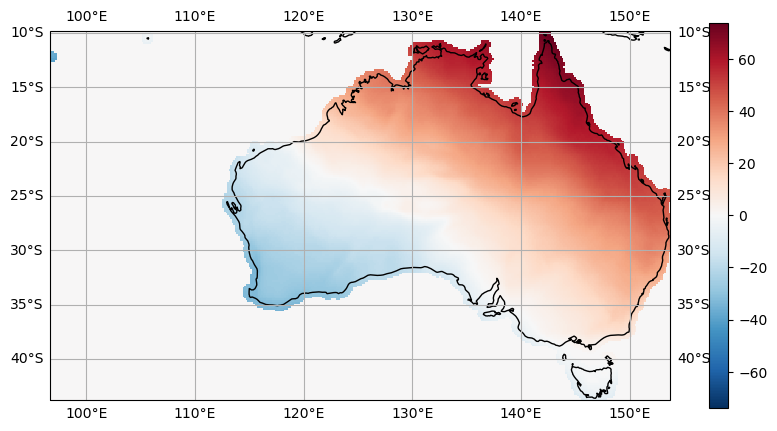

In [3]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)

z.plot(ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree())